## 課題1（Jobshop）: FCFS と OR-Tools 最適化の比較（実行用ノートブック）

このノートブックは、READMEの課題1を **再現可能** に実行して、
- FCFS（先着順）
- OR-Tools（メイクスパン最小）
- OR-Tools（重み付き完了時刻和最小：3パターン）
- 自作ジョブ
の結果（表・ガントチャート）を生成します。

### 事前準備
- Python 3.10+ 推奨
- 依存関係: `requirements.txt`

> もしこの環境でまだ未インストールなら、次セルを実行してください。


In [1]:
from pathlib import Path

import pandas as pd

from task1.jobshop_data import instance_assignment_jobs, instance_custom_jobs, weight_patterns
from task1.fcfs_sim import simulate_fcfs
from task1.ortools_jobshop import solve_makespan, solve_weighted_completion_sum
from task1.viz import save_gantt, schedule_to_dataframe

OUT = Path("../task1_outputs_nb")
OUT.mkdir(parents=True, exist_ok=True)
OUT.resolve()


PosixPath('/Users/yutotakagi/Develop/task1_outputs_nb')

### (1) 指定ジョブ（README記載）: FCFS と OR-Tools（makespan最小）の比較


In [2]:
from IPython.display import Image, display

inst = instance_assignment_jobs()
inst


JobshopInstance(name='assignment_jobs', jobs=[[(0, 3), (1, 2), (2, 2)], [(0, 2), (2, 1), (1, 4)], [(1, 4), (2, 3)], [(1, 2), (0, 1), (2, 4)], [(2, 1), (0, 2), (1, 1)]])

In [3]:
out = OUT / inst.name
out.mkdir(parents=True, exist_ok=True)

# FCFS
fcfs = simulate_fcfs(inst)
df_fcfs = schedule_to_dataframe(fcfs.ops)
df_fcfs.to_csv(out / f"{inst.name}_fcfs_ops.csv", index=False)
save_gantt(
    fcfs.ops,
    out / f"{inst.name}_fcfs_gantt.png",
    title=f"{inst.name}: FCFS (makespan={fcfs.makespan})",
    num_machines=inst.num_machines,
)

# OR-Tools (makespan min)
opt_ms = solve_makespan(inst, time_limit_s=10.0)
df_ms = schedule_to_dataframe(opt_ms.ops)
df_ms.to_csv(out / f"{inst.name}_opt_makespan_ops.csv", index=False)
save_gantt(
    opt_ms.ops,
    out / f"{inst.name}_opt_makespan_gantt.png",
    title=f"{inst.name}: OR-Tools makespan-min (makespan={opt_ms.makespan})",
    num_machines=inst.num_machines,
)

summary = pd.DataFrame(
    [
        {"method": "FCFS", "makespan": fcfs.makespan, **{f"C{j}": c for j, c in enumerate(fcfs.job_completion)}},
        {"method": "OR-Tools makespan-min", "makespan": opt_ms.makespan, **{f"C{j}": c for j, c in enumerate(opt_ms.job_completion)}},
    ]
)
summary


,method,makespan,C0,C1,C2,C3,C4
0,FCFS,14,14,13,7,12,9
1,OR-Tools makespan-min,13,12,12,10,7,13


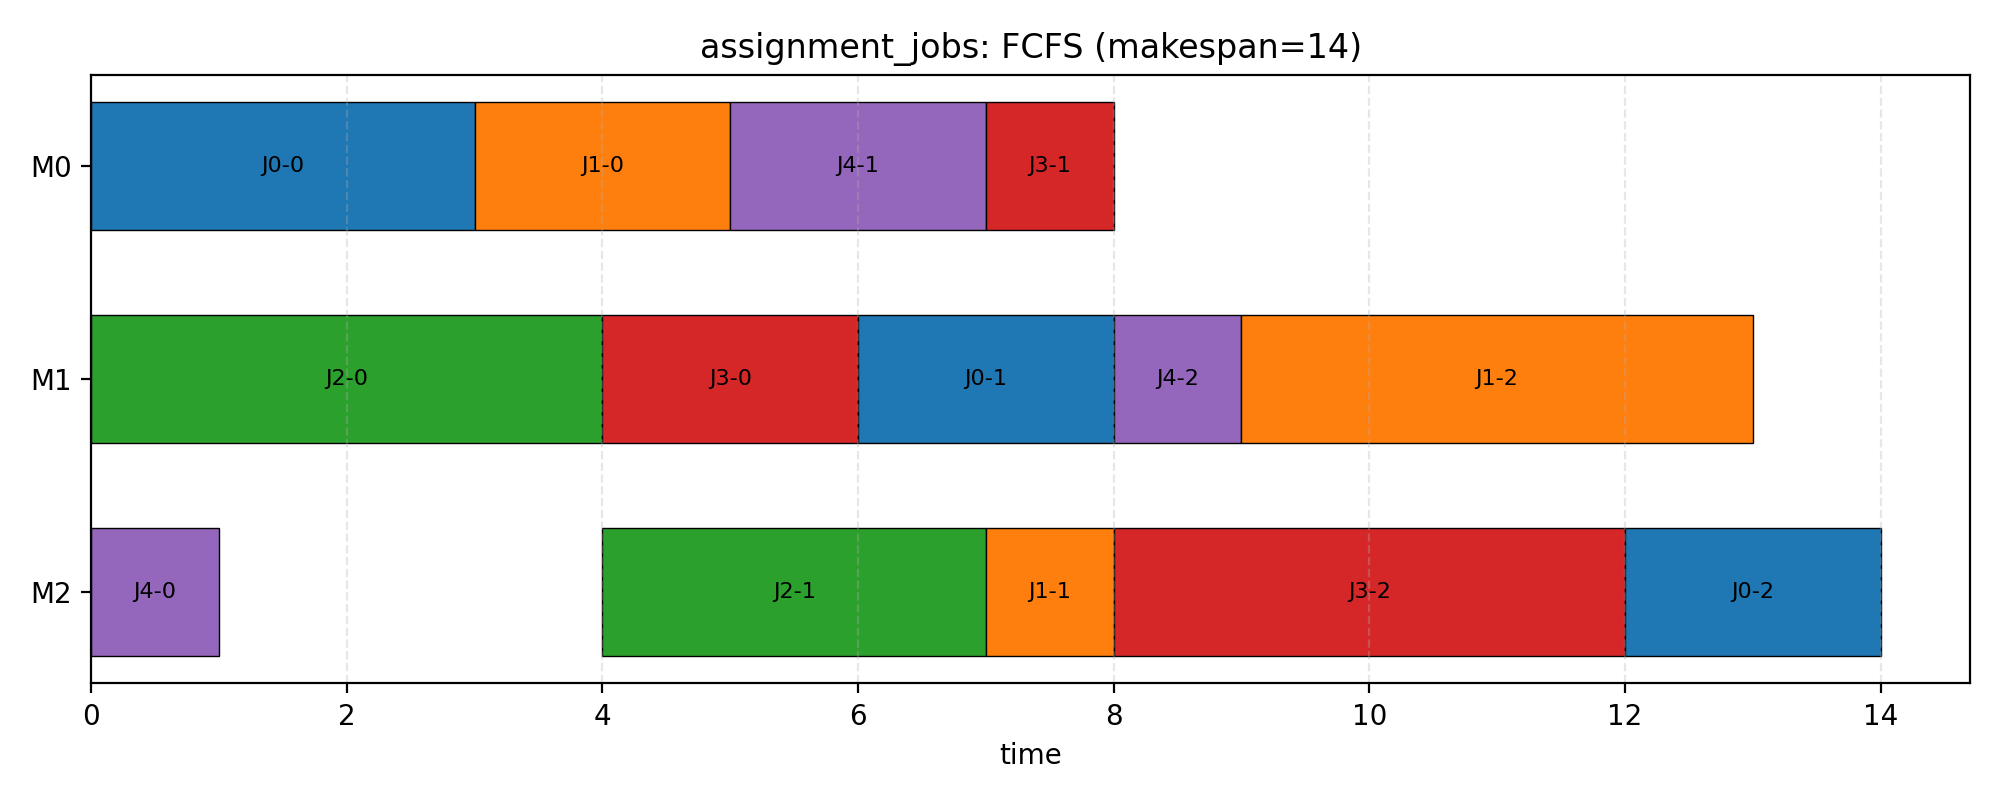

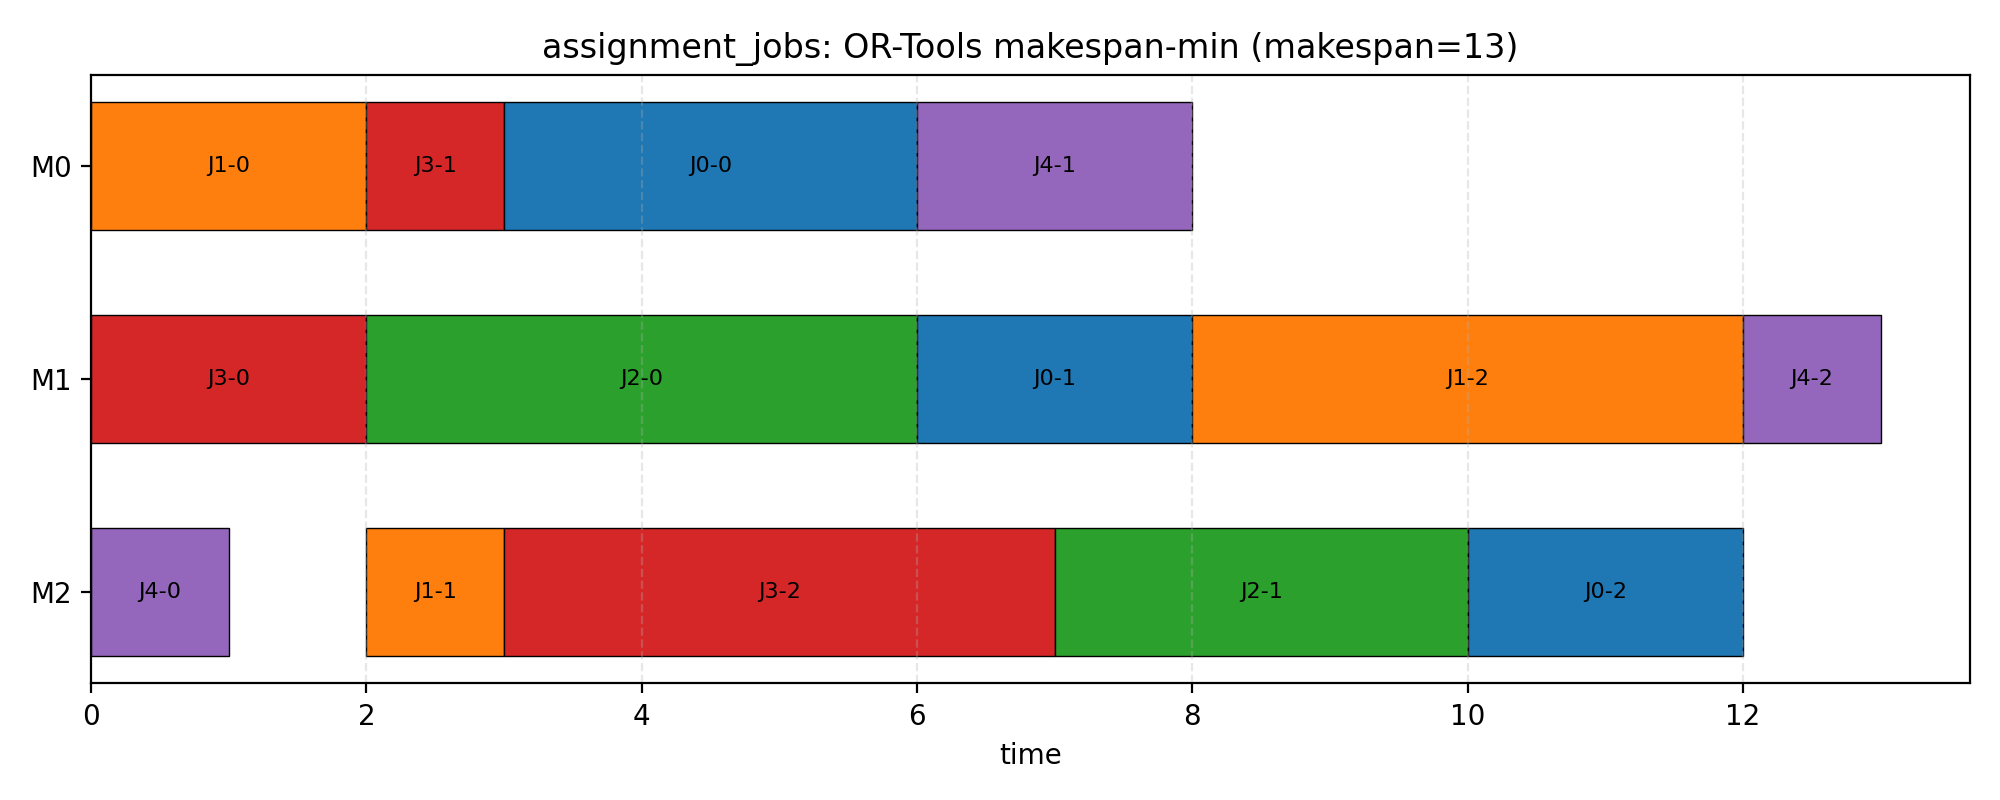

In [4]:
display(Image(filename=str(out / f"{inst.name}_fcfs_gantt.png")))
display(Image(filename=str(out / f"{inst.name}_opt_makespan_gantt.png")))
